# Modeling the first wave of COVID-19 in Massachusetts

In this tutorial we will develop an epidemic models for COVID-19 and we will calibrate it to real data on weekly deaths during the first wave in Massachusetts, US. 

Let's import needed packages:

In [30]:
import pandas as pd 
import matplotlib.pyplot as plt
from epydemix.model import EpiModel, simulate
from epydemix.population import load_epydemix_population
from epydemix.visualization import plot_quantiles, plot_posterior_distribution, plot_posterior_distribution_2d
from epydemix.calibration import ABCSampler
from epydemix.utils import compute_simulation_dates, convert_to_2Darray
from epydemix.calibration.metrics import wmape
import numpy as np 
from datetime import datetime
from scipy import stats 

Second, we import and plot the epidemic data on weekly COVID-19 deaths that we want to model ([source](https://usafacts.org/visualizations/coronavirus-covid-19-spread-map/state/new-york/)):

Text(0.5, 1.0, 'Massachusetts - Weekly COVID-19 Deaths')

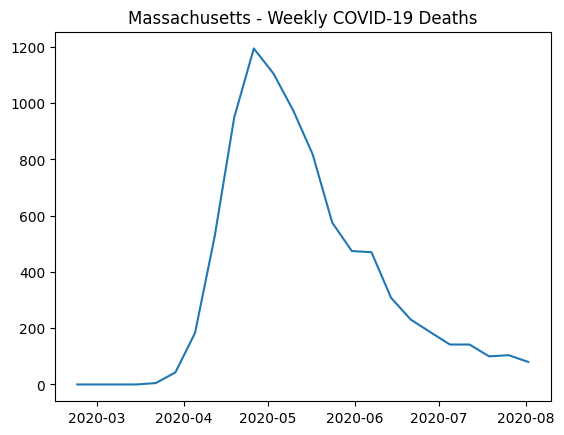

In [31]:
epi_data = pd.read_csv("./data/massachusetts_data/MA_deaths.csv", parse_dates=["date"])
plt.plot(epi_data.date, epi_data.data)
plt.title("Massachusetts - Weekly COVID-19 Deaths")


Then, we import mobility data from the COVID-19 Community Mobility Report published by Google. Since the first wave of COVID-19 was controlled via the implementation of non-pharmaceutical interventions, we need to account for this into our model. We will use mobility data to compute a contact reduction parameter $r(t)$ that will modulate the transmission rate of our epidemic model. For more detail on similar approaches see [here](https://www.medrxiv.org/content/10.1101/2024.11.08.24316998v1).

Text(0, 0.5, '$r(t)$')

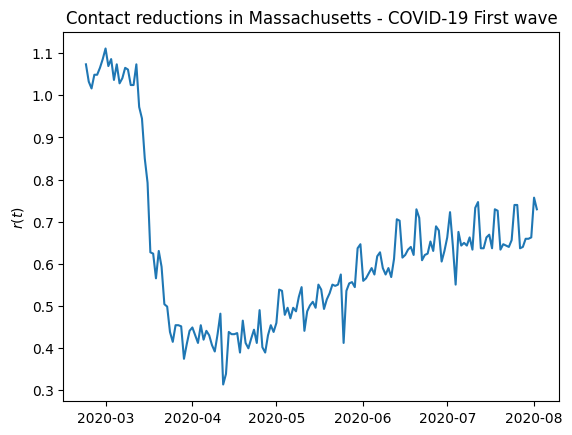

In [32]:
def compute_contact_reductions(mob_data, columns=['retail_and_recreation_percent_change_from_baseline', 
                                                  'grocery_and_pharmacy_percent_change_from_baseline',
                                                  'transit_stations_percent_change_from_baseline', 
                                                  'workplaces_percent_change_from_baseline', 
                                                  'residential_percent_change_from_baseline']):
    return pd.DataFrame(data={'date': mob_data.date, 'r': (1 + mob_data[columns].mean(axis=1) / 100)**2})

# import google data and compute contacts reduction
mob_data = pd.read_csv(f'./data/massachusetts_data/MA_google.csv', parse_dates=["date"])
mob_data = mob_data.loc[(mob_data.date >= epi_data.date.min()) & (mob_data.date <= epi_data.date.max())]
contact_reductions = compute_contact_reductions(mob_data=mob_data)
plt.plot(contact_reductions.date, contact_reductions.r)
plt.title("Contact reductions in Massachusetts - COVID-19 First wave")
plt.ylabel("$r(t)$")

We are ready to create the epidemic model. We will implement a SEIR-like model, with the addition of compartments to represent COVID-19 deaths. The model follows this schema:

MODEL SCHEMA

The multiple $D_i$ compartments are introduced to make the transitions from recovery to deaths Erlang distributed. 

In [33]:
# define Epydemix model
model = EpiModel(compartments=["S", "E", "I", "R", "D0", "D1", "D2", "D3", "D4"])

# set population with 10 age groups
population_ma = load_epydemix_population("United_States_Massachusetts", 
                                          age_group_mapping={"0-9": np.arange(0, 10).astype(str),
                                                            "10-19": np.arange(10, 20).astype(str),
                                                            "20-29": np.arange(20, 30).astype(str),
                                                            "30-39": np.arange(30, 40).astype(str),
                                                            "40-49": np.arange(40, 50).astype(str),
                                                            "50-59": np.arange(50, 60).astype(str),
                                                            "60-69": np.arange(60, 70).astype(str),
                                                            "70-79": np.arange(70, 80).astype(str), 
                                                            "80+": np.concatenate((np.arange(80, 84), ["84+"])).astype(str)})
model.set_population(population_ma)
model.add_parameter(parameters_dict={"mu": 1. / 2.5, 
                                     "eps": 1. / 4., 
                                     "r": contact_reductions["r"].values, 
                                     "IFR": convert_to_2Darray([0.00161/100, 0.00695/100, 0.0309/100, 0.0844/100, 0.161/100, 
                                                                0.595/100, 1.93/100, 4.28/100, 7.80/100])})

model.add_transition(source="S", target="E", params=("beta*r", "I"), kind="mediated")
model.add_transition(source="E", target="I", params="eps", kind="spontaneous")
model.add_transition(source="I", target="R", params="mu*(1-IFR)", kind="spontaneous")
model.add_transition(source="I", target="D0", params="mu*IFR", kind="spontaneous")
model.add_transition(source="D0", target="D1", params="4./Delta", kind="spontaneous")
model.add_transition(source="D1", target="D2", params="4./Delta", kind="spontaneous")
model.add_transition(source="D2", target="D3", params="4./Delta", kind="spontaneous")
model.add_transition(source="D3", target="D4", params="4./Delta", kind="spontaneous")

In [34]:
def apply_seasonality(start_date, end_date, seasonality_min, seasonality_max=1):
    seasonality_factors = []
    start_date, end_date = pd.to_datetime(start_date), pd.to_datetime(end_date)
    for day in pd.date_range(start_date, end_date):
        day_max=datetime(day.year, 1, 15)
        s_r = seasonality_min / seasonality_max
        seasonality_factors.append(0.5 * ((1 - s_r) * np.sin(2 * np.pi / 365 * (day - day_max).days + 0.5 * np.pi) + 1 + s_r))
    return np.array(seasonality_factors)

C = np.sum([c for _, c in model.population.contact_matrices.items()], axis=0)
def compute_beta(C, mu, R0): 
    return R0 * mu / np.linalg.eigvals(C).real.max()

We are almost ready for the calibration:

In [35]:
def custom_initial_conditions(epimodel, I0): 
    infected_by_age = np.random.multinomial(I0, epimodel.population.Nk / epimodel.population.Nk.sum())
    return {"S": epimodel.population.Nk - infected_by_age, 
            "E": (infected_by_age / 2).astype(int),
            "I": (infected_by_age / 2).astype(int)}

def simulate_wrapper(parameters): 
    # set initial conditions
    initial_conditions = custom_initial_conditions(parameters["epimodel"], parameters["I0"])
    parameters.update({"initial_conditions_dict": initial_conditions})
    # compute beta from R0 
    beta0 = compute_beta(C, parameters["epimodel"].parameters["mu"], parameters["R0"])
    # compute seasonality factor
    sesonal_factor = apply_seasonality(parameters["start_date"],  parameters["end_date"], parameters["seasonality_min"])
    parameters.update({"beta": beta0 * sesonal_factor})
    results = simulate(**parameters)
    return {"data": results.transitions["D3_to_D4_total"]}


priors = {"R0": stats.uniform(1.5, 6.0 - 1.5), 
          "Delta": stats.randint(7, 28),
          "I0": stats.randint(10, 9990),
          "seasonality_min": stats.uniform(0.6, 1.0 - 0.6), }

simulation_dates = compute_simulation_dates(start_date=epi_data.date.values[0], end_date=epi_data.date.values[-1])
parameters = {"epimodel": model, 
              "start_date": epi_data.date.values[0], 
              "end_date": epi_data.date.values[-1], 
              "resample_frequency": "W"}

In [36]:
# initialize the ABCSampler object
abc_sampler = ABCSampler(simulation_function=simulate_wrapper, 
                         priors=priors, 
                         parameters=parameters, 
                         observed_data=epi_data["data"].values, 
                         distance_function=wmape)

# Run ABC-SMC
results = abc_sampler.calibrate(strategy="smc", num_particles=100, num_generations=10)

Starting ABC-SMC with 100 particles and 10 generations

Generation 1/10 (epsilon: inf)
	Accepted 100/100 (acceptance rate: 100.00%)
	Elapsed time: 00:00:21

Generation 2/10 (epsilon: 4.045592)
	Accepted 100/199 (acceptance rate: 50.25%)
	Elapsed time: 00:00:44

Generation 3/10 (epsilon: 1.607794)
	Accepted 100/226 (acceptance rate: 44.25%)
	Elapsed time: 00:00:56

Generation 4/10 (epsilon: 0.837670)
	Accepted 100/279 (acceptance rate: 35.84%)
	Elapsed time: 00:01:02

Generation 5/10 (epsilon: 0.670926)
	Accepted 100/262 (acceptance rate: 38.17%)
	Elapsed time: 00:00:56

Generation 6/10 (epsilon: 0.524219)
	Accepted 100/382 (acceptance rate: 26.18%)
	Elapsed time: 00:01:25

Generation 7/10 (epsilon: 0.423220)
	Accepted 100/413 (acceptance rate: 24.21%)
	Elapsed time: 00:01:37

Generation 8/10 (epsilon: 0.354629)
	Accepted 100/850 (acceptance rate: 11.76%)
	Elapsed time: 00:02:56

Generation 9/10 (epsilon: 0.307120)
	Accepted 100/578 (acceptance rate: 17.30%)
	Elapsed time: 00:01:40

Gen

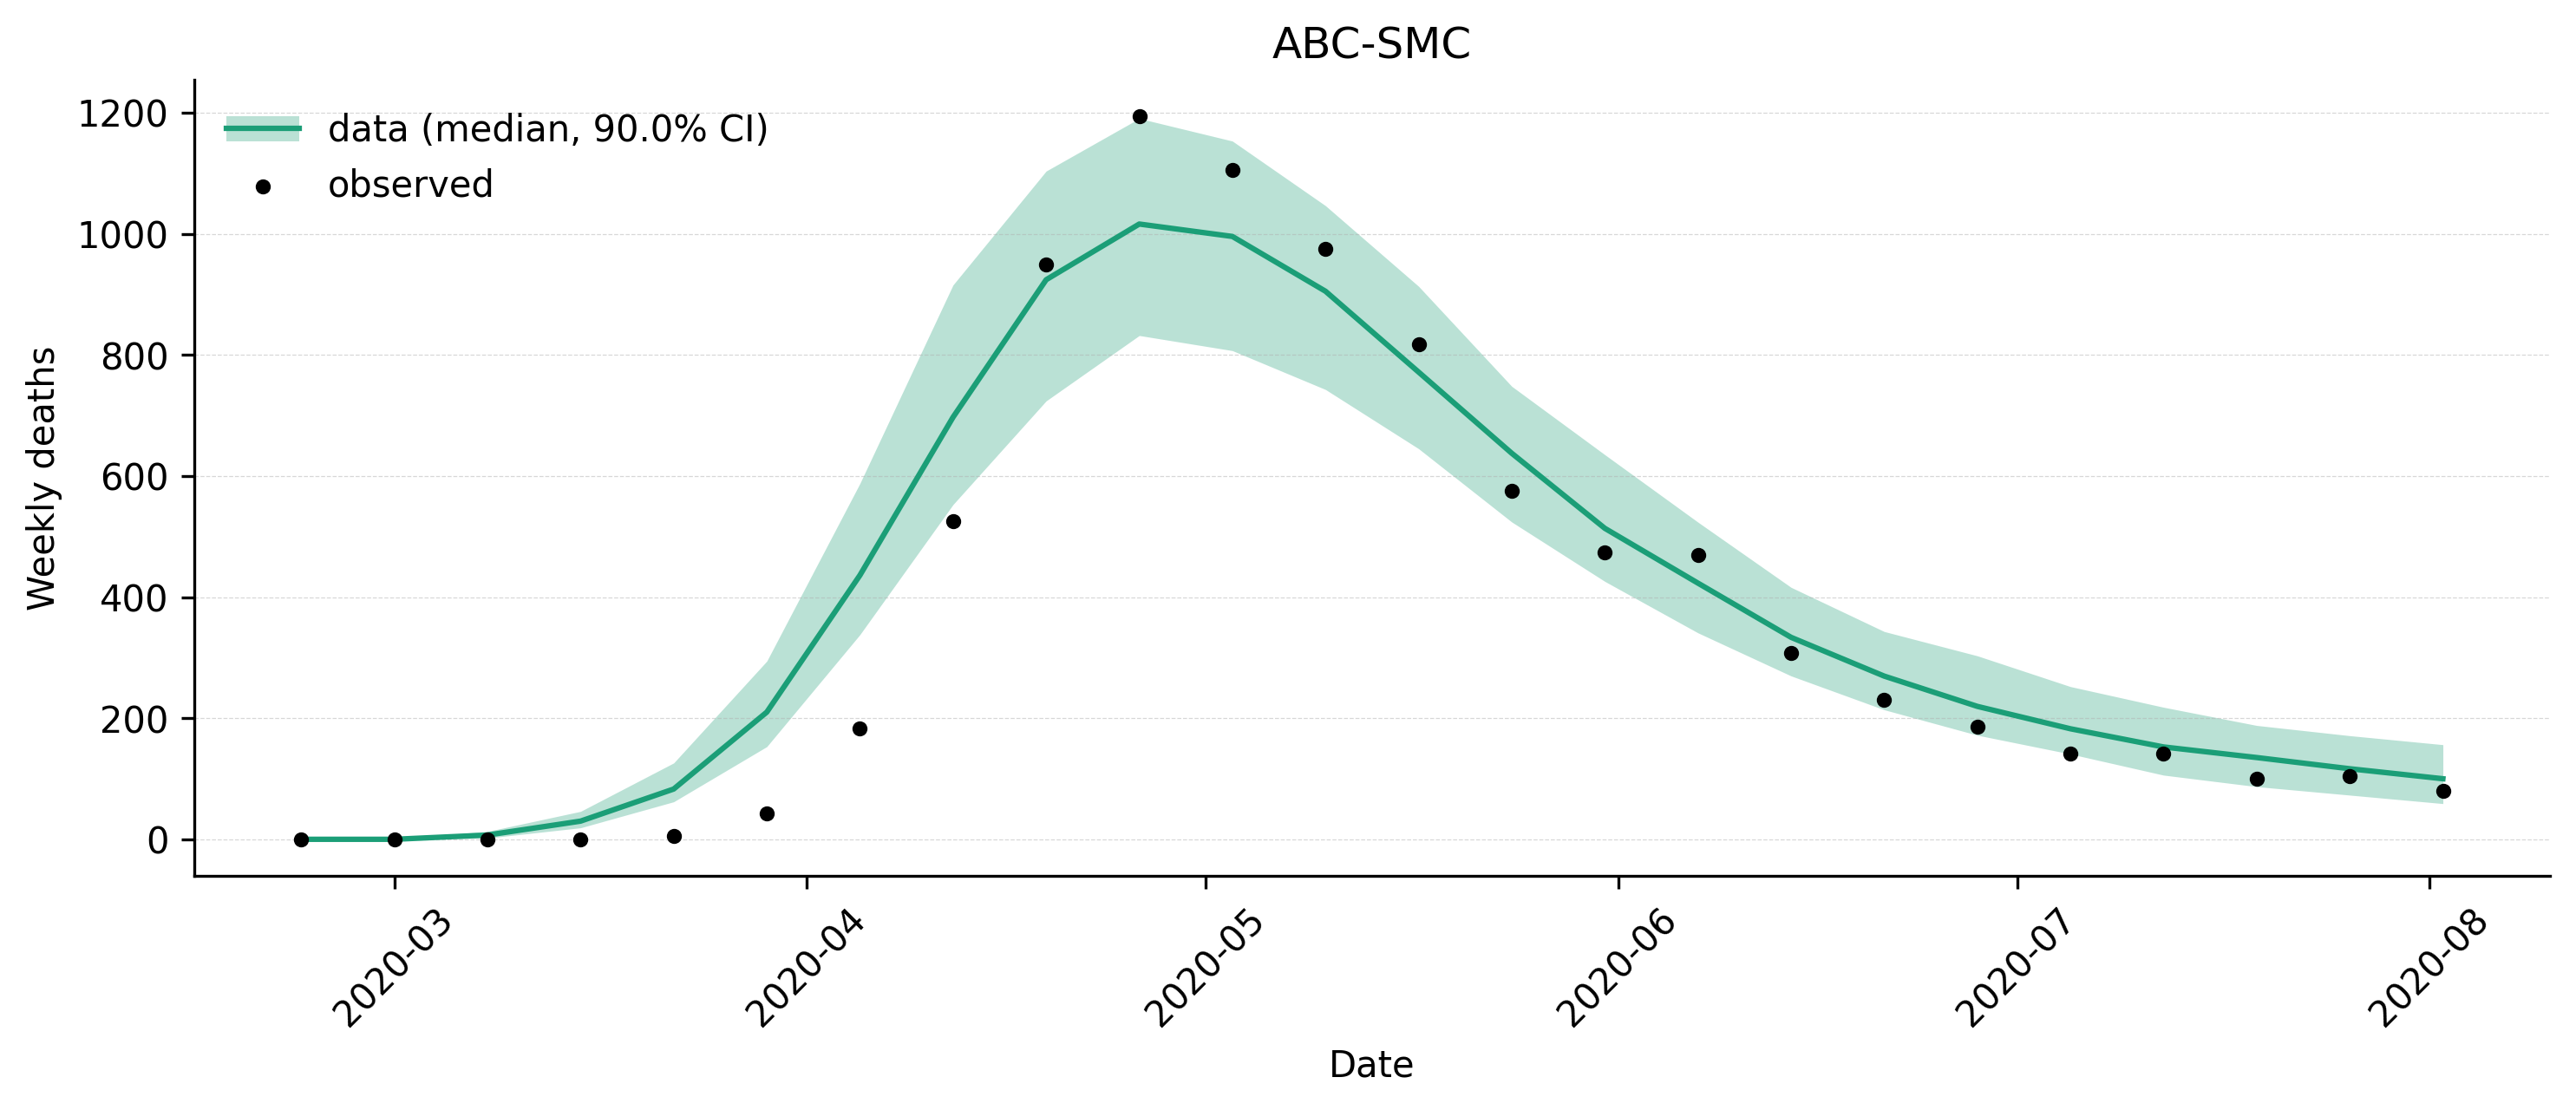

In [37]:
ax = plot_quantiles(results.get_calibration_quantiles(dates=epi_data.date.values), 
                    data=epi_data, columns="data", title="ABC-SMC", show_data=True, 
                    xlabel="Date", ylabel="Weekly deaths")   
ax.tick_params(axis='x', labelrotation=45)


In [16]:
median_epx_res = results.get_calibration_quantiles(dates=epi_data.date.values)
median_epx_res = median_epx_res.loc[median_epx_res["quantile"] == 0.5]

In [17]:
wmape({"data": epi_data.data.values}, {"data": median_epx_res.data.values})


0.17888256475781159

In [ ]:
plot_posterior_distribution(results.get_posterior_distribution(), "detection_rate", kind="kde")

In [ ]:
plot_posterior_distribution(results.get_posterior_distribution(), "R0", kind="kde")

In [ ]:
plot_posterior_distribution(results.get_posterior_distribution(), "seasonality_min", kind="kde")

In [ ]:
plot_posterior_distribution_2d(results.get_posterior_distribution(), "Delta", "I0", kind="kde")

In [ ]:
np.linalg.eigvals(C).real.max()

In [ ]:
C_p = np.load("./data/ny_state/new_york/contact_matrix/contact_matrix.npz")['arr_0']
np.linalg.eigvals(C_p).real.max()

In [ ]:
epi_data_p = pd.read_csv("./data/ny_state/new_york/epi-data/epi_data.csv")
epi_data_p.date = pd.to_datetime(epi_data_p.date)
epi_data_p.set_index("date", inplace=True)
epi_data_p = epi_data_p.resample("W").sum()
epi_data_p = epi_data_p.loc[(epi_data_p.index >= epi_data.date.values[0]) & (epi_data_p.index <= epi_data.date.values[-1])]
epi_data_p["new_deaths"].plot()
epi_data["data"].plot()

In [68]:
epi_data_p.reset_index(inplace=True)

In [71]:
mob_data = pd.read_csv(f'./data/ny_state/NY_google.csv')
mob_data = mob_data.loc[(mob_data.date >= epi_data.date.min()) & (mob_data.date <= epi_data.date.max())]
contact_reductions = compute_contact_reductions(mob_data=mob_data, 
                                                columns=['retail_and_recreation_percent_change_from_baseline',
                                                        'grocery_and_pharmacy_percent_change_from_baseline',
                                                        'transit_stations_percent_change_from_baseline',
                                                        'workplaces_percent_change_from_baseline',
                                                        'residential_percent_change_from_baseline'])
contact_reductions["date"] = pd.to_datetime(contact_reductions["date"])

In [72]:
from datetime import datetime, timedelta
# merge epi and contacts data 
tot_data = pd.merge(contact_reductions, epi_data_p, how='left', on='date')
tot_data.date = pd.to_datetime(tot_data.date)

# select simulation period
start_date, end_date = datetime(year=2020, month=3, day=8), datetime(year=2020, month=8, day=2)
if start_date - timedelta(days=30) < tot_data.date.min():
        tot_data_simulation = tot_data.loc[tot_data.date <= end_date].reset_index(drop=True)
else:
        tot_data_simulation = tot_data.loc[(tot_data.date >= start_date - timedelta(days=30)) & (tot_data.date <= end_date)].reset_index(drop=True)
tot_data_evaluation = tot_data.loc[(tot_data.date >= start_date) & (tot_data.date <= end_date)].reset_index(drop=True)


In [ ]:
tot_data_evaluation

In [ ]:
tot_data_simulation

In [ ]:
import pyabc
import uuid
import os
from pyabc import RV, Distribution, DiscreteJumpTransition, MultivariateNormalTransition, AggregatedTransition
import tempfile
from pyabc.sampler import MulticoreEvalParallelSampler

def make_model(epimodel, param): 
    def model(p): 
        # run model 
        model_param = {**p, **param}
        return epimodel(model_param)
    return model



def wmape_pyabc(sim_data, actual_data) -> float:
    return np.sum(np.abs(actual_data['data'] - sim_data['data'])) / np.sum(np.abs(actual_data['data']))


pyabc_priors = Distribution(R0=RV("uniform", 1.5, 6.0 - 1.5),
                            Delta=RV('rv_discrete', values=(np.arange(7, 35), [1 / 28] * 28)),
                            I0=RV('rv_discrete', values=(np.arange(10, 10000), [1 / 9990] * 9990)), 
                            seasonality_min=RV("uniform", 0.6, 1.0 - 0.6), 
                            detection_rate=RV("uniform", 0.5, 1.0 - 0.5))

transitions = AggregatedTransition(mapping={"I0": DiscreteJumpTransition(domain=np.arange(10, 10000), p_stay=0.7), 
                                            "R0": MultivariateNormalTransition(), 
                                            "Delta": DiscreteJumpTransition(domain=np.arange(7, 35), p_stay=0.7),
                                            "seasonality_min": MultivariateNormalTransition(), 
                                            "detection_rate": MultivariateNormalTransition()})


abc = pyabc.ABCSMC(make_model(simulate_wrapper, parameters), 
                    pyabc_priors, 
                    distance_function=wmape_pyabc, 
                    transitions=transitions, 
                    population_size=100, 
                    sampler=MulticoreEvalParallelSampler(n_procs=8))

db_path = os.path.join(tempfile.gettempdir(), "test_1.db")
abc.new("sqlite:///" + db_path, {"data": epi_data["data"].values})
history = abc.run(max_nr_populations=7)


In [ ]:
samples = np.array([d["data"] for d in history.get_weighted_sum_stats()[1]])
xs = np.arange(len(samples[0]))
plt.plot(xs, np.median(samples, axis=0))
plt.fill_between(xs, np.percentile(samples, 5.0, axis=0), np.percentile(samples, 95.0, axis=0), alpha=0.2)
plt.plot(xs, epi_data["data"].values, color="black")

epx_res = results.get_calibration_quantiles()

median_epx_res = epx_res.loc[epx_res["quantile"] == 0.5]
plt.plot(xs, median_epx_res["data"], color="red")
plt.fill_between(xs, epx_res.loc[epx_res["quantile"] == 0.05]["data"], epx_res.loc[epx_res["quantile"] == 0.95]["data"], alpha=0.2, color="red")
plt.plot(xs, epi_data["data"].values, color="black")

In [ ]:
posterior_pyabc = history.get_distribution()[0]

import seaborn as sns
ax = plot_posterior_distribution(results_rejection.get_posterior_distribution(), "R0", kind="kde")
plot_posterior_distribution(results.get_posterior_distribution(), "R0", kind="kde", color="red", ax=ax)
sns.kdeplot(posterior_pyabc["R0"], ax=ax)

In [ ]:
ax = plot_posterior_distribution(results_rejection.get_posterior_distribution(), "I0", kind="kde")
plot_posterior_distribution(results.get_posterior_distribution(), "I0", kind="kde", color="red", ax=ax)
sns.kdeplot(posterior_pyabc["I0"], ax=ax)

In [ ]:
ax = plot_posterior_distribution(results_rejection.get_posterior_distribution(), "Delta", kind="kde")
plot_posterior_distribution(results.get_posterior_distribution(), "Delta", kind="kde", color="red", ax=ax)

sns.kdeplot(posterior_pyabc["Delta"], ax=ax)

In [ ]:
ax = plot_posterior_distribution(results_rejection.get_posterior_distribution(), "seasonality_min", kind="kde")
plot_posterior_distribution(results.get_posterior_distribution(), "seasonality_min", kind="kde", color="red", ax=ax)
sns.kdeplot(posterior_pyabc["seasonality_min"], ax=ax)

In [ ]:
ax = plot_posterior_distribution(results_rejection.get_posterior_distribution(), "detection_rate", kind="kde")
plot_posterior_distribution(results.get_posterior_distribution(), "detection_rate", kind="kde", color="red", ax=ax)

sns.kdeplot(posterior_pyabc["detection_rate"], ax=ax)

In [ ]:
weights_pyabc = history.get_weighted_sum_stats()[0]
weights_epx_rej = results_rejection.get_weights()
weights_epx = results.get_weights()


sns.kdeplot(weights_pyabc, label="PyABC")
sns.kdeplot(weights_epx, label="Epydemix")



In [ ]:
print(np.max(weights_epx))
print(np.max(weights_pyabc))

In [ ]:

posterior_epx_rej = results_rejection.get_posterior_distribution()
posterior_epx = results.get_posterior_distribution()

sns.kdeplot(data=posterior_pyabc, x="I0", y="Delta", cmap="viridis")
plt.show()
sns.kdeplot(data=posterior_epx, x="I0", y="Delta", cmap="viridis")
plt.show()
sns.kdeplot(data=posterior_epx_rej, x="I0", y="Delta", cmap="viridis")
plt.show()


In [ ]:
import seaborn as sns
ax = plot_posterior_distribution(results_rejection.get_posterior_distribution(), "R0", kind="kde")
ax = plot_posterior_distribution(results_rejection.get_posterior_distribution(), "I0", kind="kde")


In [ ]:
blues = sns.color_palette("Blues", 8)
for i in range(8):
    pr = results.get_posterior_distribution(i)
    sns.kdeplot(pr["R0"], color=blues[i], fill=True)
    print(np.median(pr["R0"]))
